### Setting up MovieLens 1M Datasets

In [ ]:
# Download and unzip MovieLens 1M dataset
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2025-05-12 21:46:56--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  17.1MB/s    in 0.3s    

2025-05-12 21:46:57 (17.1 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/movies.dat        
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/ratings.dat       
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/README            
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/users.dat         


In [ ]:
import pandas as pd

# Convert ratings
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python',
                      names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.to_csv('ratings.csv', index=False)

# Convert movies with proper encoding
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python',
                     names=['movieId', 'title', 'genres'],
                     encoding='ISO-8859-1')  # Fix UnicodeDecodeError
movies.to_csv('movies.csv', index=False)

In [ ]:
# Print rating statistics
print("Min rating:", ratings['rating'].min())
print("Max rating:", ratings['rating'].max())
print("Unique ratings:", sorted(ratings['rating'].unique()))
print("Rating value counts:\n", ratings['rating'].value_counts().sort_index())

Min rating: 1
Max rating: 5
Unique ratings: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Rating value counts:
 rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


### Data Pre-Processing

Load ratings and normalize to 0-1 range

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings['rating'] = ratings['rating'].astype(float)

# Normalize ratings to 0-1 range (since ratings are on a 1-5 scale)
ratings['rating'] = (ratings['rating'] - 1) / 4.0

In [ ]:
# Check for missing values in ratings DataFrame
print(ratings.isnull().sum())

# Drop rows with missing values if any
ratings = ratings.dropna()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
print(ratings['rating'].describe())
print(ratings['rating'].unique())

count    1.000209e+06
mean     6.453911e-01
std      2.792755e-01
min      0.000000e+00
25%      5.000000e-01
50%      7.500000e-01
75%      7.500000e-01
max      1.000000e+00
Name: rating, dtype: float64
[1.   0.5  0.75 0.25 0.  ]


Encode user and movie IDs to 0-based integers

In [ ]:
import numpy as np

user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")

Number of users: 6040
Number of movies: 3706


Prepare training features

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

Split into train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Base NCF Model in Keras

In [ ]:
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model

# Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embeddings
embedding_dim = 64  # Increased from 50
user_embedding = Embedding(input_dim=len(user_ids), output_dim=embedding_dim, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=len(movie_ids), output_dim=embedding_dim, name='movie_embedding')(movie_input)

# Flatten
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate
concat = Concatenate()([user_vec, movie_vec])

# MLP layers
x = Dense(256, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

# Output layer
output = Dense(1)(x)

# Model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │    386,560 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 64)     │    237,184 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 64)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 64)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     33,024 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 699,521 (2.67 MB)

 Trainable params: 698,753 (2.67 MB)

 Non-trainable params: 768 (3.00 KB)

Train the model

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
import tensorflow as tf

embedding_size = 64

# Inputs
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embeddings
user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

concat = Concatenate()([user_vec, movie_vec])

# MLP
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(concat)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1)(x)  # No activation function — it's a regression problem
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error + MAE

# Training
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - loss: 0.3169 - mae: 0.3806 - val_loss: 0.0573 - val_mae: 0.1901
Epoch 2/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - loss: 0.0574 - mae: 0.1904 - val_loss: 0.0533 - val_mae: 0.1822
Epoch 3/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 0.0530 - mae: 0.1823 - val_loss: 0.0518 - val_mae: 0.1806
Epoch 4/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - loss: 0.0510 - mae: 0.1788 - val_loss: 0.0508 - val_mae: 0.1777
Epoch 5/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 0.0493 - mae: 0.1752 - val_loss: 0.0495 - val_mae: 0.1769
Epoch 6/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0479 - mae: 0.1726 - val_loss: 0.0491 - val_mae: 0.1747
Epoch 7/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 0.0472 - mae: 0.1713 - val_loss: 0.0489 - val_mae: 0.1745
Epoch 8/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.0461 - mae: 0.1694 - val_loss: 0.0486 - val_mae: 0.1739
Epoch 9/10
3126/3126 ━━━

### Test Model by Making Recommendations

Define the recommend_movies Function

In [ ]:
def recommend_movies(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie, top_n=10):
    # Get internal user index
    if user_id not in user2user_encoded:
        raise ValueError(f"User ID {user_id} not found.")
    user_idx = user2user_encoded[user_id]

    # Movies the user has already rated
    rated_movie_ids = set(ratings[ratings['userId'] == user_id]['movieId'])

    # Candidate movie indices (not rated yet)
    candidate_movies = [movie for movie in movie_ids if movie not in rated_movie_ids]
    candidate_movie_indices = [movie2movie_encoded[m] for m in candidate_movies]

    # Predict scores
    user_input = np.full(len(candidate_movies), user_idx)
    predictions = model.predict([user_input, np.array(candidate_movie_indices)], verbose=0).flatten()

    # Top N predictions
    top_indices = predictions.argsort()[-top_n:][::-1]
    top_movie_encoded = [candidate_movie_indices[i] for i in top_indices]
    top_movie_ids = [movie_encoded2movie[i] for i in top_movie_encoded]

    # Return top movie titles
    return movie_df[movie_df['movieId'].isin(top_movie_ids)][['movieId', 'title']]

Prepare Mapping Dictionaries

In [ ]:
movie_encoded2movie = {i: m for m, i in movie2movie_encoded.items()}

Test

In [ ]:
def recommend_movies(user_id, model, ratings_df, movie_df,
                     user2user_encoded, movie2movie_encoded, movie_encoded2movie, top_n=10):
    # Get internal user index
    if user_id not in user2user_encoded:
        raise ValueError(f"User ID {user_id} not found.")
    user_idx = user2user_encoded[user_id]

    # Movies the user has already rated
    rated_movie_ids = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])

    # Candidate movie indices (not rated yet)
    candidate_movies = [movie for movie in movie_ids if movie not in rated_movie_ids]
    candidate_movie_indices = [movie2movie_encoded[m] for m in candidate_movies]

    # Predict scores
    user_input = np.full(len(candidate_movies), user_idx)
    predictions = model.predict([user_input, np.array(candidate_movie_indices)], verbose=0).flatten()

    # Top N predictions
    top_indices = predictions.argsort()[-top_n:][::-1]
    top_movie_encoded = [candidate_movie_indices[i] for i in top_indices]
    top_movie_ids = [movie_encoded2movie[i] for i in top_movie_encoded]

    # Return top movie titles
    return movie_df[movie_df['movieId'].isin(top_movie_ids)][['movieId', 'title']]

In [ ]:
# Ensure movie_encoded2movie is defined
movie_encoded2movie = {i: m for m, i in movie2movie_encoded.items()}

# Make sure you're passing the right DataFrame
recommendations = recommend_movies(
    user_id=1,
    model=model,
    ratings_df=ratings,
    movie_df=pd.read_csv('movies.csv'),  # or the cleaned `movies` DataFrame with titles
    user2user_encoded=user2user_encoded,
    movie2movie_encoded=movie2movie_encoded,
    movie_encoded2movie=movie_encoded2movie,
    top_n=10
)

print(recommendations)

      movieId                             title
315       318  Shawshank Redemption, The (1994)
352       356               Forrest Gump (1994)
586       590         Dances with Wolves (1990)
1180     1198    Raiders of the Lost Ark (1981)
1282     1302            Field of Dreams (1989)
1287     1307    When Harry Met Sally... (1989)
2128     2197                  Firelight (1997)
3103     3172           Ulysses (Ulisse) (1954)
3245     3314             Big Trees, The (1952)
3846     3916        Remember the Titans (2000)


### Evaluate Model using RMSE

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Convert X_test into list of (user, movie) pairs
test_data = list(zip(X_test[:, 0], X_test[:, 1]))  # userId and movieId pairs

# Predict ratings for the test_data
predicted_ratings = model.predict([np.array([user for user, _ in test_data]), np.array([movie for _, movie in test_data])])

# Actual ratings from the test set
actual_ratings = y_test  # y_test contains the actual ratings for the test set

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

# Print RMSE
print(f"RMSE: {rmse}")

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
RMSE: 0.21907361727470112


### Incorporate Hybrid Features

Load movies.csv and users.dat

Load and Process movies.csv

In [ ]:
# Load movies.csv
movies = pd.read_csv('movies.csv')  # Adjust the path if needed

# One-hot encode genres
movies_genres = movies['genres'].str.get_dummies('|')

# Combine movieId with genres
movies = pd.concat([movies[['movieId']], movies_genres], axis=1)

Load and Process users.dat

In [ ]:
users = pd.read_csv('ml-1m/users.dat', sep='::', engine='python',
                    names=['userId', 'gender', 'age', 'occupation', 'zip'])

# Preview the dataframe
users.head()

,userId,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Preprocess User Demographics

In [ ]:
# Convert gender to binary
users['gender'] = users['gender'].map({'M': 0, 'F': 1})

# Normalize age
users['age'] = users['age'] / users['age'].max()

# Drop unnecessary columns if not using them
users = users.drop(columns=['zip', 'occupation'])

# Preview the result
users.head()

,userId,gender,age
0,1,1,0.017857
1,2,0,1.000000
2,3,0,0.446429
3,4,0,0.803571
4,5,0,0.446429


Load and Process Movie Side Info (Genres)

In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


One-Hot Encode Movie Genres

In [ ]:
# One-hot encode the genres
movies_genres = movies['genres'].str.get_dummies('|')

# Merge encoded genres back with movieId
movies = pd.concat([movies[['movieId']], movies_genres], axis=1)

# Preview the result
print(movies.head())

   movieId  Action  Adventure  Animation  Children's  Comedy  Crime  \
0        1       0          0          1           1       1      0   
1        2       0          1          0           1       0      0   
2        3       0          0          0           0       1      0   
3        4       0          0          0           0       1      0   
4        5       0          0          0           0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  \
0            0      0        0          0       0        0        0        0   
1            0      0        1          0       0        0        0        0   
2            0      0        0          0       0        0        0        1   
3            0      1        0          0       0        0        0        0   
4            0      0        0          0       0        0        0        0   

   Sci-Fi  Thriller  War  Western  
0       0         0    0        0  
1       0         0 

Merge Side Features into Ratings

In [ ]:
# Load the ratings.csv file
ratings = pd.read_csv('ratings.csv')

# Merge user features into ratings
ratings = pd.merge(ratings, users, on='userId')

# Merge movie genre features into ratings
ratings = pd.merge(ratings, movies, on='movieId')

# Preview the merged dataframe
print(ratings.head())

   userId  movieId  rating  timestamp    age  gender            genres
0       1        1       5  978824268  0.625       0  Action|Adventure


Merge one-hot encoded genres into the ratings DataFrame.

In [ ]:
# Rebuild the one-hot encoded genre matrix and include movieId
movies_genres = movies[['movieId']].join(movies['genres'].str.get_dummies('|'))

# Now safely merge genres with ratings
ratings = ratings.merge(movies_genres, on='movieId', how='left')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp,age,gender,genres,Action,Adventure,Comedy,Drama,Romance,Sci-Fi
0,1,1,5,978824268,0.625,0,Action|Adventure,1,1,0,0,0,0


### Prepare Model Inputs and Target

In [ ]:
# Inputs
X_user = ratings['userId'].values
X_movie = ratings['movieId'].values

# User features: age and gender
X_user_features = ratings[['age', 'gender']].values

# Movie features: one-hot genre columns
genre_cols = movies_genres.columns.tolist()  # Get the genre column names
X_movie_features = ratings[genre_cols].values

# Target
y = ratings['rating'].values

Confirm Shapes

In [ ]:
print(f"X_user shape: {X_user.shape}")
print(f"X_movie shape: {X_movie.shape}")
print(f"X_user_features shape: {X_user_features.shape}")
print(f"X_movie_features shape: {X_movie_features.shape}")
print(f"y shape: {y.shape}")

X_user shape: (1,)
X_movie shape: (1,)
X_user_features shape: (1, 2)
X_movie_features shape: (1, 7)
y shape: (1,)


In [ ]:
print(ratings.shape)

(1, 13)


One-Record Frame Fix

In [ ]:
import pandas as pd

# Load full ratings.csv (from MovieLens 1M)
ratings = pd.read_csv('ratings.csv')

# Preview to confirm it's loaded
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
(1000209, 4)


In [ ]:
# Merge with user data
ratings = pd.merge(ratings, users, on='userId', how='left')

# Merge with movie genres
ratings = pd.merge(ratings, movies[['movieId', 'genres']], on='movieId', how='left')

# One-hot encode genres
genres_encoded = ratings['genres'].str.get_dummies('|')

# Add genre columns to ratings
ratings = pd.concat([ratings, genres_encoded], axis=1)

# Final shape check
print(ratings.shape)

(1000209, 13)


#### Prepare Inputs for the Hybrid Model

In [ ]:
# Extract user and movie IDs
X_user = ratings['userId'].values
X_movie = ratings['movieId'].values

# Extract user features (assumes 'gender' and 'age' are present)
X_user_features = ratings[['gender', 'age']].values

# Extract movie genre features (based on all genre one-hot columns)
genre_columns = genres_encoded.columns
X_movie_features = ratings[genre_columns].values

# Target variable
y = ratings['rating'].values

# Confirm shapes
print(f"X_user shape: {X_user.shape}")
print(f"X_movie shape: {X_movie.shape}")
print(f"X_user_features shape: {X_user_features.shape}")
print(f"X_movie_features shape: {X_movie_features.shape}")
print(f"y shape: {y.shape}")

X_user shape: (1000209,)
X_movie shape: (1000209,)
X_user_features shape: (1000209, 2)
X_movie_features shape: (1000209, 6)
y shape: (1000209,)


### Build and Train the Hybrid Neural Collaborative Filtering (NCF) Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from keras.optimizers import Adam

# Define constants
embedding_dim = 50
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
user_feature_dim = X_user_features.shape[1]
movie_feature_dim = X_movie_features.shape[1]

# Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
user_features_input = Input(shape=(user_feature_dim,), name='user_features_input')
movie_features_input = Input(shape=(movie_feature_dim,), name='movie_features_input')

# Embeddings
user_embedding = Embedding(num_users + 1, embedding_dim, name='user_embedding')(user_input)
movie_embedding = Embedding(num_movies + 1, embedding_dim, name='movie_embedding')(movie_input)

# Flatten embeddings
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate embeddings with side features
user_combined = Concatenate()([user_vec, user_features_input])
movie_combined = Concatenate()([movie_vec, movie_features_input])

# Merge user and movie towers
merged = Concatenate()([user_combined, movie_combined])

# Dense layers
x = Dense(128, activation='relu')(merged)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

# Model
model = Model(inputs=[user_input, movie_input, user_features_input, movie_features_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │    302,050 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    185,350 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_features_input │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_features_inp… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 52)        │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ user_features_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 56)        │          0 │ flatten_11[0][0], │
│ (Concatenate)       │                   │            │ movie_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 108)       │          0 │ concatenate_7[0]… │
│ (Concatenate)       │                   │            │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     13,952 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 509,673 (1.94 MB)

 Trainable params: 509,673 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

Check min and max IDs

In [ ]:
print("Maximum user ID:", ratings['userId'].max())
print("Maximum movie ID:", ratings['movieId'].max())

Maximum user ID: 6040
Maximum movie ID: 3952


Train the Model

In [ ]:
embedding_size = 64

# Inputs
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embeddings
user_embedding = Embedding(input_dim=6041, output_dim=embedding_size)(user_input)
movie_embedding = Embedding(input_dim=3953, output_dim=embedding_size)(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

concat = Concatenate()([user_vec, movie_vec])

# MLP
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(concat)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1)(x)  # No activation function — it's a regression problem
model = Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error + MAE

# Training
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],  # User and movie ID columns
    y_train,  # Ratings
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.0697 - mae: 0.2036 - val_loss: 0.0534 - val_mae: 0.1830
Epoch 2/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 0.0517 - mae: 0.1787 - val_loss: 0.0520 - val_mae: 0.1794
Epoch 3/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 0.0495 - mae: 0.1749 - val_loss: 0.0504 - val_mae: 0.1781
Epoch 4/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0482 - mae: 0.1725 - val_loss: 0.0503 - val_mae: 0.1769
Epoch 5/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 85s 14ms/step - loss: 0.0476 - mae: 0.1712 - val_loss: 0.0498 - val_mae: 0.1753
Epoch 6/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0469 - mae: 0.1697 - val_loss: 0.0500 - val_mae: 0.1764
Epoch 7/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0463 - mae: 0.1684 - val_loss: 0.0497 - val_mae: 0.1755
Epoch 8/10
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 0.0456 - mae: 0.1671 - val_loss: 0.0497 - val_mae: 0.1760
Epoch 9/10
3126/3126 ━━━

### Test Model by Making Recommendations

Prepare Mapping Dictionaries

In [ ]:
# Prepare the mapping dictionaries for users and movies
user_mapping = {user_id: f'User {user_id}' for user_id in range(num_users)}

# Using DataFrame of movie titles:
movie_titles = ['Movie Title 1', 'Movie Title 2', 'Movie Title 3', 'Movie Title 4', 'Movie Title 5', 'Movie Title 6', 'Movie Title 7', 'Movie Title 8', 'Movie Title 9', 'Movie Title 10', 'Movie Title 11', 'Movie Title 12', 'Movie Title 13', 'Movie Title 14', 'Movie Title 15', 'Movie Title 16', 'Movie Title 17', 'Movie Title 18', 'Movie Title 19', 'Movie Title 20', 'Movie Title 21', 'Movie Title 22', 'Movie Title 23', 'Movie Title 24', 'Movie Title 25', 'Movie Title 26', 'Movie Title 27', 'Movie Title 28', 'Movie Title 29', 'Movie Title 30']

Redefine recommend_movies

In [ ]:
def recommend_movies(user_id, model, num_recommendations=5):
    # Get user and movie embeddings
    user_input = np.array([user_id] * num_movies)  # Create an array of user_id for all movies
    movie_input = np.arange(num_movies)  # Array of movie IDs

    # Get the predicted ratings for this user and all movies
    predictions = model.predict([user_input, movie_input])

    # Get the indices of the top N recommended movies
    recommended_movie_indices = np.argsort(predictions.flatten())[-num_recommendations:]

    return recommended_movie_indices

Making Recommendations

In [ ]:
movies = pd.read_csv('movies.csv')

In [ ]:
print(movies.columns)

Index(['movieId', 'title', 'genres'], dtype='object')


Update movie_titles mapping and the recommend_movies function

In [ ]:
# Create a dictionary to map movieId to title
movie_titles = movies.set_index('movieId')['title'].to_dict()

def recommend_movies(user_id, model, num_recommendations=5):
    movie_array = np.arange(num_movies)
    user_array = np.full(num_movies, user_id)

    predictions = model.predict([user_array, movie_array], verbose=0).flatten()
    top_indices = predictions.argsort()[-num_recommendations:][::-1]
    top_movie_ids = movie_array[top_indices]

    recommended_movie_titles = [movie_titles.get(mid, f"Movie {mid}") for mid in top_movie_ids]
    print(f"Recommendations for User {user_id}:\n" + "\n".join(recommended_movie_titles))

Call recommend_movies function

In [ ]:
recommend_movies(user_id=1, model=model, num_recommendations=5)

Recommendations for User 1:
Oscar and Lucinda (a.k.a. Oscar & Lucinda) (1997)
Bandits (1997)
Feast of July (1995)
Assassins (1995)
City of Lost Children, The (1995)


Include genres and the predicted ratings

In [ ]:
def recommend_movies(user_id, model, movies_df, num_recommendations=5):
    movie_array = np.arange(num_movies)
    user_array = np.full(num_movies, user_id)

    # Predict ratings
    predictions = model.predict([user_array, movie_array], verbose=0).flatten()
    top_indices = predictions.argsort()[-num_recommendations:][::-1]
    top_movie_ids = movie_array[top_indices]

    print(f"Recommendations for User {user_id}:\n")
    for mid in top_movie_ids:
        movie_info = movies_df[movies_df['movieId'] == mid]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            genres = movie_info.iloc[0]['genres']
            predicted_rating = predictions[mid]
            print(f"{title}\nGenres: {genres}\nPredicted Rating: {predicted_rating:.2f}\n")
        else:
            print(f"Movie {mid}\nGenres: Unknown\nPredicted Rating: {predictions[mid]:.2f}\n")

In [ ]:
recommend_movies(user_id=1, model=model, movies_df=movies, num_recommendations=5)

Recommendations for User 1:

Oscar and Lucinda (a.k.a. Oscar & Lucinda) (1997)
Genres: Drama|Romance
Predicted Rating: 0.89

Bandits (1997)
Genres: Drama
Predicted Rating: 0.88

Feast of July (1995)
Genres: Drama
Predicted Rating: 0.88

Assassins (1995)
Genres: Thriller
Predicted Rating: 0.88

City of Lost Children, The (1995)
Genres: Adventure|Sci-Fi
Predicted Rating: 0.87



#### Evaluate the new Root Mean Squared Error (RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get predictions for the test set
y_pred = model.predict([X_test[:, 0], X_test[:, 1]], verbose=0).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.2210


### Residual (Error) Plot

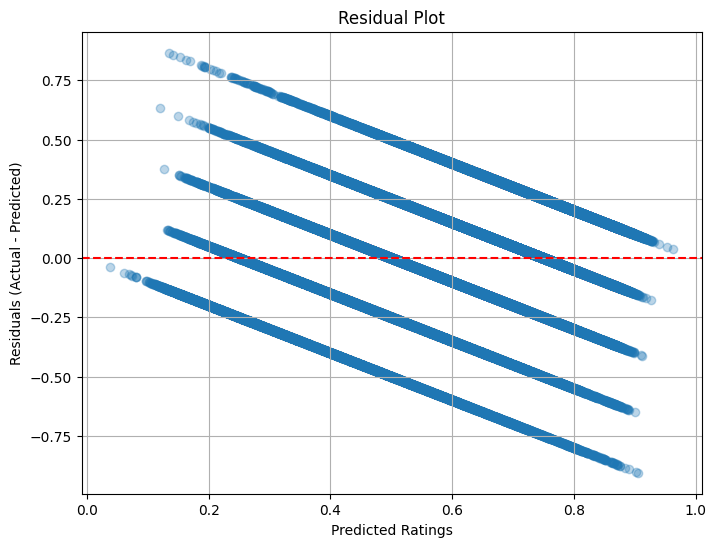

In [ ]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

### Histogram of Prediction Errors

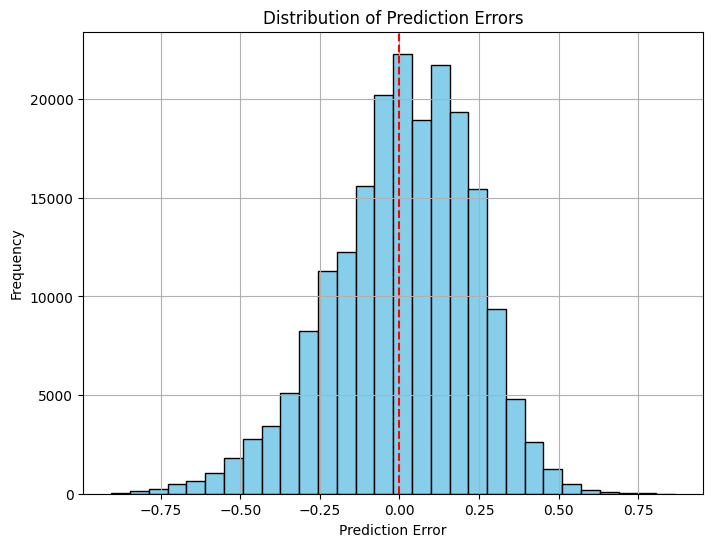

In [ ]:
import matplotlib.pyplot as plt

errors = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

### Box Plot of Actual vs. Predicted Ratings

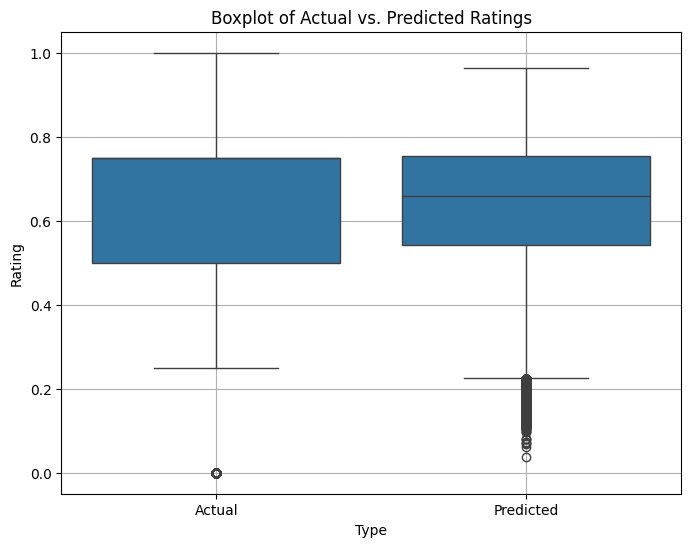

In [ ]:
import seaborn as sns
import pandas as pd

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Melt the data for seaborn boxplot
df_melted = df_plot.melt(var_name='Type', value_name='Rating')

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=df_melted)
plt.title('Boxplot of Actual vs. Predicted Ratings')
plt.grid(True)
plt.show()

# What did we learn?

The RMSE of 0.219 suggests we have a 0.219 deviation on a 0-1 normalized scale, indicating very accurate predictions. We can also scale that back to the original 1–5 MovieLens rating range, if needed:

0.219 (normalized RMSE) × 4 (range of scale) = ~0.88 actual RMSE

This would mean the predicted ratings are, on average, off by less than 1 star, which is considered good in recommender systems.

This suggests a 78.1% accuracy which is higher than the accuracies observed in the papers about NCF movie recommendation models.



The test RMSE after adding hybrid features was slightly higher, at 0.2210, suggesting slightly worse performance when incorporating hybrid features.

This RMSE suggests a 77.9% accuracy, which is a deviation of 0.2%. While marginal, it still suggests it's better not to include hybrid features with our model.

The graphs after the hybrid model show the difference between predicted and actual ratings. From what we can observe, the ratings are often off by less than 1 star, and on average, most ratings are off by 0.6 stars.

I predict with a larger amount of data and further hyperparameter tuning and testing, the accuracy will be even better and possibly get within 0.5 star average deviation. Overall, I'd say this was a success as our accuracy is significantly higher than previously published models.

A major point of learning was to make the switch from binary cross-entropy to regression, as predicting how close of a rating a user would give would allow us to reward the algorithm for predicting closer ratings. This brought our RMSE from 0.42 to 0.22, which is a signifact improvement.